In [82]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

In [83]:
obesity_dataset = pd.read_csv('Data/obesity.csv')

# Data Analysis

### columns:
*    Gender: Gender
*    Age: Age
*    Height : in metres
*    Weight : in kgs
*    family_history : Has a family member suffered or suffers from overweight?
*    FAVC : Do you eat high caloric food frequently?
*    FCVC : Do you usually eat vegetables in your meals?
*    NCP : How many main meals do you have daily?
*    CAEC : Do you eat any food between meals?
*    SMOKE : Do you smoke?
*    CH2O : How much water do you drink daily?
*    SCC : Do you monitor the calories you eat daily?
*    FAF: How often do you have physical activity?
*    TUE : How much time do you use technological devices such as cell phone, videogames, television, computer and others?
*    CALC : How often do you drink alcohol?
*    MTRANS : Which transportation do you usually use?
*    Obesity_level (Target Column) : Obesity level


In [84]:
duplicates = obesity_dataset[obesity_dataset.duplicated()]
print(f"Number of duplicates: {duplicates.shape[0]}")

Number of duplicates: 24


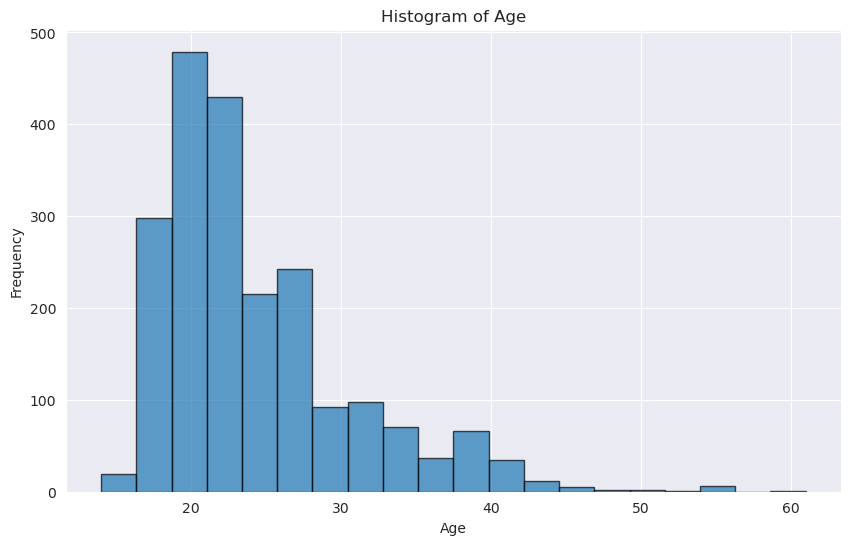

In [85]:
plt.figure(figsize=(10, 6))
plt.hist(obesity_dataset['Age'], bins=20, edgecolor='k', alpha=0.7)
plt.title('Histogram of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

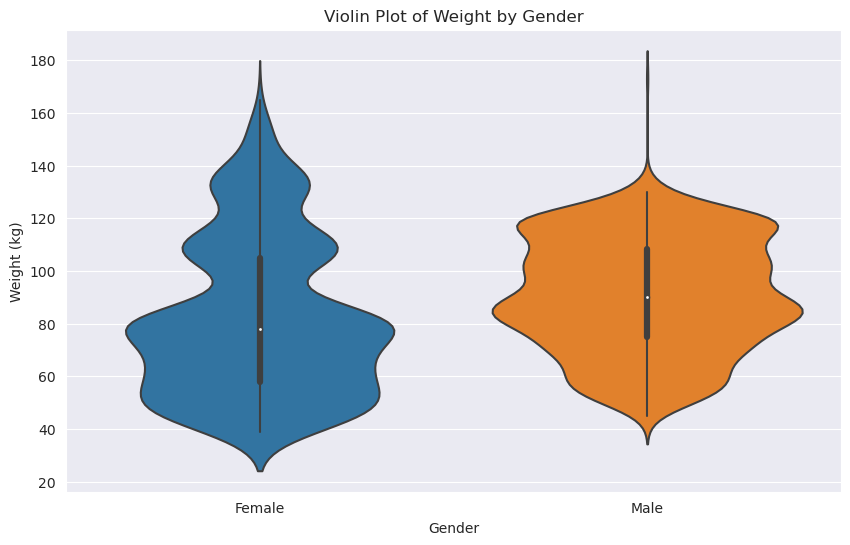

In [86]:
plt.figure(figsize=(10, 6))
sns.violinplot(x='Gender', y='Weight', data=obesity_dataset)
plt.title('Violin Plot of Weight by Gender')
plt.xlabel('Gender')
plt.ylabel('Weight (kg)')
plt.show()

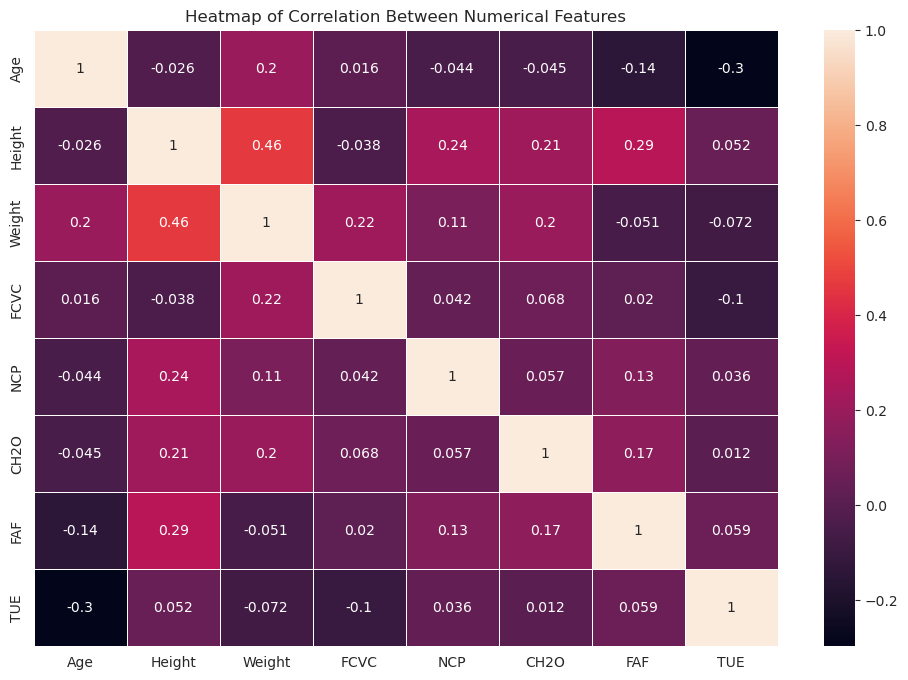

In [87]:
# Heatmap for correlation between numerical features
plt.figure(figsize=(12, 8))
correlation_matrix = obesity_dataset.corr(numeric_only=True)
sns.heatmap(correlation_matrix, annot=True, linewidths=0.5)
plt.title('Heatmap of Correlation Between Numerical Features')
plt.show()

# Data Preprocessing

In [88]:
obesity_dataset = obesity_dataset.drop_duplicates()

duplicates = obesity_dataset[obesity_dataset.duplicated()]
print(f"Number of duplicates: {duplicates.shape[0]}")

Number of duplicates: 0


In [89]:
obesity_dataset = obesity_dataset.drop(columns=['Height', 'Weight'])

# Linear Regression

# Random Forest

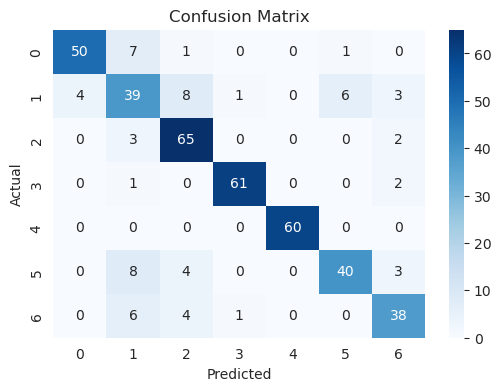

In [97]:
# encode for random forest

label_enc = LabelEncoder()

obesity_dataset['Obesity'] = label_enc.fit_transform(obesity_dataset['Obesity'])

categorical_features = ['Gender', 'family_history', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS']
obesity_categorized = pd.get_dummies(obesity_dataset, columns=categorical_features, drop_first=True)

# split data

X = obesity_categorized.drop('Obesity', axis=1)
y = obesity_categorized['Obesity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# train random forest

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# confusion matrix

y_pred = clf.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_enc.classes_, yticklabels=label_enc.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()